### Test of data instantiation

In [135]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchmetrics import FBetaScore, Accuracy
import pandas as pd
from PIL import Image
import os
from src import BWDatasets
import cv2

In [ ]:
from paddleocr import PaddleOCR as POCR

ocr = POCR(lang="en", use_doc_orientation_classify=True, use_doc_unwarping=True, use_textline_orientation=True)



c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2954.78it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\le

In [ ]:
label_path = "dataset/datasets/rf/ringcodes.csv"
image_path = "dataset/datasets/rf/images"
bb_path = "dataset/datasets/rf/labels"
max_n = 100
transform = T.Compose([
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])
exp_dataset = BWDatasets.TrainDataSet(img_path=image_path, labels_path=label_path, bb_path=bb_path, transform=transform, max_n=max_n)


In [155]:
def bb_txt_to_list(bb_path):
    
    with open(bb_path) as f:
        line = f.readline().strip()

        bb = line.split(' ')
    
    return bb

In [156]:
def calculate_bb_cords(image, bb):

    img_w = image.shape[2]
    img_h = image.shape[1]

    # Calculate x and y coordinates of the bb
    bb_x = img_w * float(bb[1])
    bb_y = img_h * float(bb[2])

    # Calculate height and width of the bb, and divide by 2
    bb_w = (image.shape[2] * float(bb[3])) / 2
    bb_h = (image.shape[1] * float(bb[4])) / 2

    # Calculate corners of bb
    min_x = max(0, bb_x - (bb_w))
    max_x = min(img_w, bb_x + (bb_w))
    min_y = max(0, bb_y - (bb_h))
    max_y = min(img_h, bb_y + (bb_h))

    return min_x, min_y, max_x, max_y


In [157]:
def draw_image_with_bb(img, bb_cords):
    # Pre process image
    img_uint8 = (img * 255).to(dtype=torch.uint8)

    # Prepare bounding boxes
    boxes = torch.tensor([[bb_cords[0], bb_cords[1], bb_cords[2], bb_cords[3]]], dtype=torch.int)

    img_boxes = draw_bounding_boxes(
        img_uint8,
        boxes,
        colors="red",
        width=2
    )
    img_boxes = img_boxes.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_boxes)
    plt.axis("off")
    plt.show()

(911.9334719999999, 470.55114, 999.065568, 601.57134)


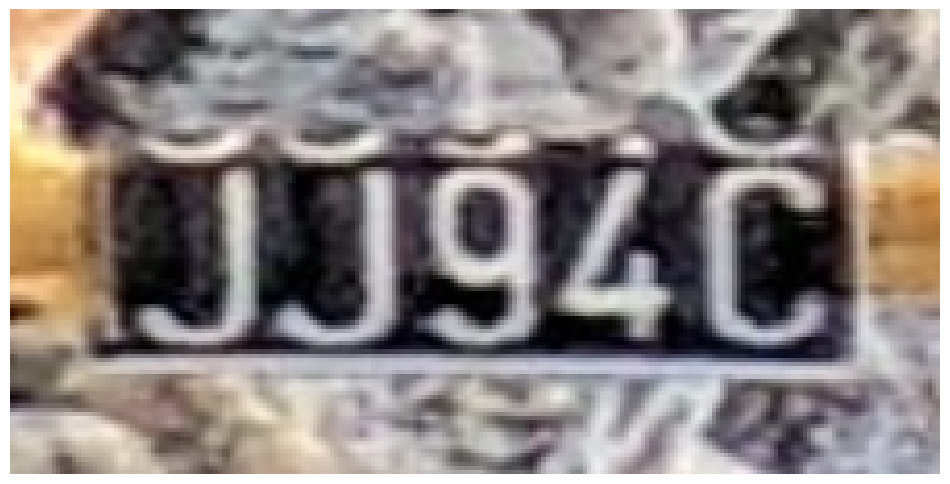

In [158]:
img, bb, l = exp_dataset[1]
print(bb)

draw_image_with_bb(img, bb)


In [159]:
# bb_folder_path = "dataset/datasets/rf/labels"

# def get_bbpath(filename, bb_folder_path):

#     bb_path = bb_folder_path + "/" +  filename[:-4] + ".txt"
    
#     return bb_path

# filename = "20240408-145102.064779(162.29,-4.57,9209.0).jpg"

# a = get_bbpath(filename=filename, bb_folder_path=bb_folder_path)

# bb = bb_txt_to_list(a)

# bb_cords = calculate_bb_cords(img, bb)
# print(bb_cords)


In [160]:
def draw_image(img):
    img_uint8 = (img * 255).to(dtype=torch.uint8)
    img_uint8 = img_uint8.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

In [161]:

def crop_image_with_bb(image, bb):
    x = int(bb[0])
    y = int(bb[1])
    width = int(bb[2]) - int(bb[0])
    height = int(bb[3]) - int(bb[1])

    img_crop = F.crop(image, top=y, left=x, height=height, width=width)
    return img_crop


In [162]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=True)


In [163]:
def prediction(dataloader):
    preds = []
    targets = []
    for images, bb, labels in dataloader:
        images = BWDatasets.tensor_to_numpy(images)
        labels = labels[0]
        for i, image in enumerate(images):

            image = (image * 255).clip(0,255).astype('uint8')
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


In [ ]:
def evaluate_model(preds, labels):
    # print(f'preds: {preds}')
    # print(f'labesl: {labels}')
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

In [165]:
#TODO: Predictions suck, supersampling?? Or is there something wrong?
preds, labels = prediction(exp_loader)


In [166]:
evaluate_model(preds=preds, labels=labels)


preds: ['J701', 'JE24X', 'WiDO', 'Not Found', '', 'Not Found', 'JE25X', 'Not Found', 'HUO', 'Not Found', 'Not Found', 'Not Found', 'JN869', 'Not Found', '#艺5', 'JC41J', 'A808', 'Not Found', 'J808V', 'Not Found', 'JE49C', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'J273H', 'Not Found', 'AOUo1', 'JC491', '0O3', 'JEZ5X', 'Not Found', 'JJ94C', 'Not Found', 'JEOOP', '9', '08931', '39000', 'JE24X', '37600', 'Not Found', 'J808V', 'Not Found', 'Not Found', 'JEGOP', 'JCOIM', 'Not Found', 'Not Found', 'JJ94C', '12TM', 'JL084', 'COC0', 'Not Found', 'Not Found', 'SOON', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'JL084', 'Not Found', 'J273H', 'Not Found', 'Not Found', 'Not Found', 'C49T', '3680', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'IE25X', 'JC49T', 'Not Found', 'Not Found', 'JN869', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'JE49C', 'JE99U', 'J761T', 'CUS6', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not Found', 'Not 